# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8213 - accuracy: 0.7344

947/947 [==============================] - 3338s 3s/step - loss: 0.8213 - accuracy: 0.7344 - val_loss: 12.4232 - val_accuracy: 0.0074
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.7581

947/947 [==============================] - 2929s 3s/step - loss: 0.7095 - accuracy: 0.7581 - val_loss: 4.4582 - val_accuracy: 0.6628
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.7700

947/947 [==============================] - 2655s 3s/step - loss: 0.6696 - accuracy: 0.7700 - val_loss: 4.0069 - val_accuracy: 0.6668
Epoch 4/200
947/947 [==============================] - 2517s 3s/step - loss: 0.6341 - accuracy: 0.7781 - val_loss: 5.3312 - val_accuracy: 0.6825
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.7869

947/947 [==============================] - 2721s 3s/step - loss: 0.6092 - accuracy: 0.7869 - val_loss: 3.5601 - val_accuracy: 0.4949
Epoch 6/200
947/947 [==============================] - 2580s 3s/step - loss: 0.5941 - accuracy: 0.7905 - val_loss: 4.4396 - val_accuracy: 0.6324
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.8002

947/947 [==============================] - 2629s 3s/step - loss: 0.5723 - accuracy: 0.8002 - val_loss: 3.3619 - val_accuracy: 0.6670
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5587 - accuracy: 0.8022

947/947 [==============================] - 2685s 3s/step - loss: 0.5587 - accuracy: 0.8022 - val_loss: 1.7754 - val_accuracy: 0.6397
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.8069

947/947 [==============================] - 2673s 3s/step - loss: 0.5472 - accuracy: 0.8069 - val_loss: 1.3222 - val_accuracy: 0.5998
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.8110

947/947 [==============================] - 2694s 3s/step - loss: 0.5339 - accuracy: 0.8110 - val_loss: 1.0355 - val_accuracy: 0.6740
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.8133

947/947 [==============================] - 2624s 3s/step - loss: 0.5262 - accuracy: 0.8133 - val_loss: 0.8494 - val_accuracy: 0.7518
Epoch 12/200
947/947 [==============================] - 2513s 3s/step - loss: 0.5166 - accuracy: 0.8190 - val_loss: 1.2243 - val_accuracy: 0.6373
Epoch 13/200
947/947 [==============================] - 2513s 3s/step - loss: 0.4988 - accuracy: 0.8225 - val_loss: 0.9636 - val_accuracy: 0.7497
Epoch 14/200
947/947 [==============================] - 2493s 3s/step - loss: 0.4959 - accuracy: 0.8253 - val_loss: 1.0982 - val_accuracy: 0.7265
Epoch 15/200
947/947 [==============================] - 2565s 3s/step - loss: 0.4877 - accuracy: 0.8263 - val_loss: 0.9405 - val_accuracy: 0.7084
Epoch 16/200
947/947 [==============================] - 2503s 3s/step - loss: 0.4795 - accuracy: 0.8318 - val_loss: 1.2340 - val_accuracy: 0.7469
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.8327

947/947 [==============================] - 2564s 3s/step - loss: 0.4722 - accuracy: 0.8327 - val_loss: 0.6475 - val_accuracy: 0.7842
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.8330

947/947 [==============================] - 2611s 3s/step - loss: 0.4696 - accuracy: 0.8330 - val_loss: 0.6134 - val_accuracy: 0.7871
Epoch 19/200
947/947 [==============================] - 2500s 3s/step - loss: 0.4547 - accuracy: 0.8373 - val_loss: 0.8625 - val_accuracy: 0.7291
Epoch 20/200
947/947 [==============================] - 2557s 3s/step - loss: 0.4549 - accuracy: 0.8370 - val_loss: 1.1634 - val_accuracy: 0.6738
Epoch 21/200
947/947 [==============================] - 2515s 3s/step - loss: 0.4415 - accuracy: 0.8440 - val_loss: 9.2685 - val_accuracy: 0.5384
Epoch 22/200
947/947 [==============================] - 2512s 3s/step - loss: 0.4373 - accuracy: 0.8442 - val_loss: 1.7758 - val_accuracy: 0.7077
Epoch 23/200
947/947 [==============================] - 2509s 3s/step - loss: 0.4283 - accuracy: 0.8481 - val_loss: 1.1325 - val_accuracy: 0.7061
Epoch 24/200
947/947 [==============================] - 2486s 3s/step - loss: 0.4192 - accuracy: 0.8495 - val_loss: 0.7390 - val_accuracy

947/947 [==============================] - 2582s 3s/step - loss: 0.4173 - accuracy: 0.8523 - val_loss: 0.5933 - val_accuracy: 0.7998
Epoch 27/200
947/947 [==============================] - 2512s 3s/step - loss: 0.4035 - accuracy: 0.8554 - val_loss: 0.9750 - val_accuracy: 0.7048
Epoch 28/200
947/947 [==============================] - 2502s 3s/step - loss: 0.3975 - accuracy: 0.8575 - val_loss: 1.2412 - val_accuracy: 0.7414
Epoch 29/200
947/947 [==============================] - 2494s 3s/step - loss: 0.3948 - accuracy: 0.8584 - val_loss: 1.2091 - val_accuracy: 0.7298
Epoch 30/200
947/947 [==============================] - 2491s 3s/step - loss: 0.3884 - accuracy: 0.8618 - val_loss: 0.7212 - val_accuracy: 0.7810
Epoch 31/200
947/947 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.8619

947/947 [==============================] - 2583s 3s/step - loss: 0.3832 - accuracy: 0.8619 - val_loss: 0.5517 - val_accuracy: 0.8143
Epoch 32/200
947/947 [==============================] - 2507s 3s/step - loss: 0.3796 - accuracy: 0.8648 - val_loss: 0.5829 - val_accuracy: 0.8073
Epoch 33/200
947/947 [==============================] - 2494s 3s/step - loss: 0.3730 - accuracy: 0.8606 - val_loss: 0.7087 - val_accuracy: 0.7482
Epoch 34/200
947/947 [==============================] - 2501s 3s/step - loss: 0.3687 - accuracy: 0.8654 - val_loss: 0.6017 - val_accuracy: 0.8016
Epoch 35/200
947/947 [==============================] - 2496s 3s/step - loss: 0.3631 - accuracy: 0.8691 - val_loss: 0.8308 - val_accuracy: 0.7873
Epoch 36/200
947/947 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8685

947/947 [==============================] - 2580s 3s/step - loss: 0.3601 - accuracy: 0.8685 - val_loss: 0.5472 - val_accuracy: 0.8165
Epoch 37/200
947/947 [==============================] - 2496s 3s/step - loss: 0.3522 - accuracy: 0.8727 - val_loss: 0.8015 - val_accuracy: 0.7432
Epoch 38/200
947/947 [==============================] - 2488s 3s/step - loss: 0.3490 - accuracy: 0.8720 - val_loss: 0.5631 - val_accuracy: 0.8027
Epoch 39/200
947/947 [==============================] - 2499s 3s/step - loss: 0.3455 - accuracy: 0.8749 - val_loss: 0.8294 - val_accuracy: 0.7402
Epoch 40/200
947/947 [==============================] - 2505s 3s/step - loss: 0.3392 - accuracy: 0.8757 - val_loss: 0.6618 - val_accuracy: 0.7889
Epoch 41/200
947/947 [==============================] - 2485s 3s/step - loss: 0.3296 - accuracy: 0.8796 - val_loss: 0.7615 - val_accuracy: 0.7600
Epoch 42/200
947/947 [==============================] - 2485s 3s/step - loss: 0.3312 - accuracy: 0.8791 - val_loss: 0.7142 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 291s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9545623198333191,
 'basal cell carcinoma': 0.9756790864173416,
 'dermatofibroma': 0.9668666461559499,
 'melanoma': 0.917874885985608,
 'nevus': 0.9577799548494272,
 'pigmented benign keratosis': 0.9766472321484546,
 'seborrheic keratosis': 0.9557956548980752,
 'solar lentigo': 0.9491392215568862,
 'squamous cell carcinoma': 0.9452196328128831,
 'vascular lesion': 0.9891691616766467}

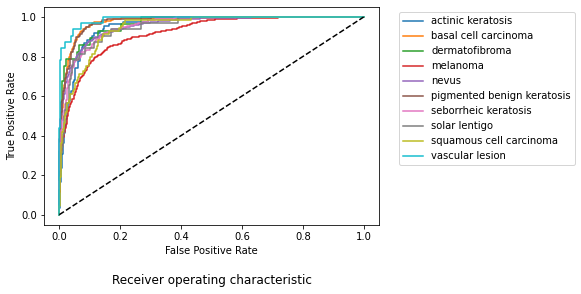

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

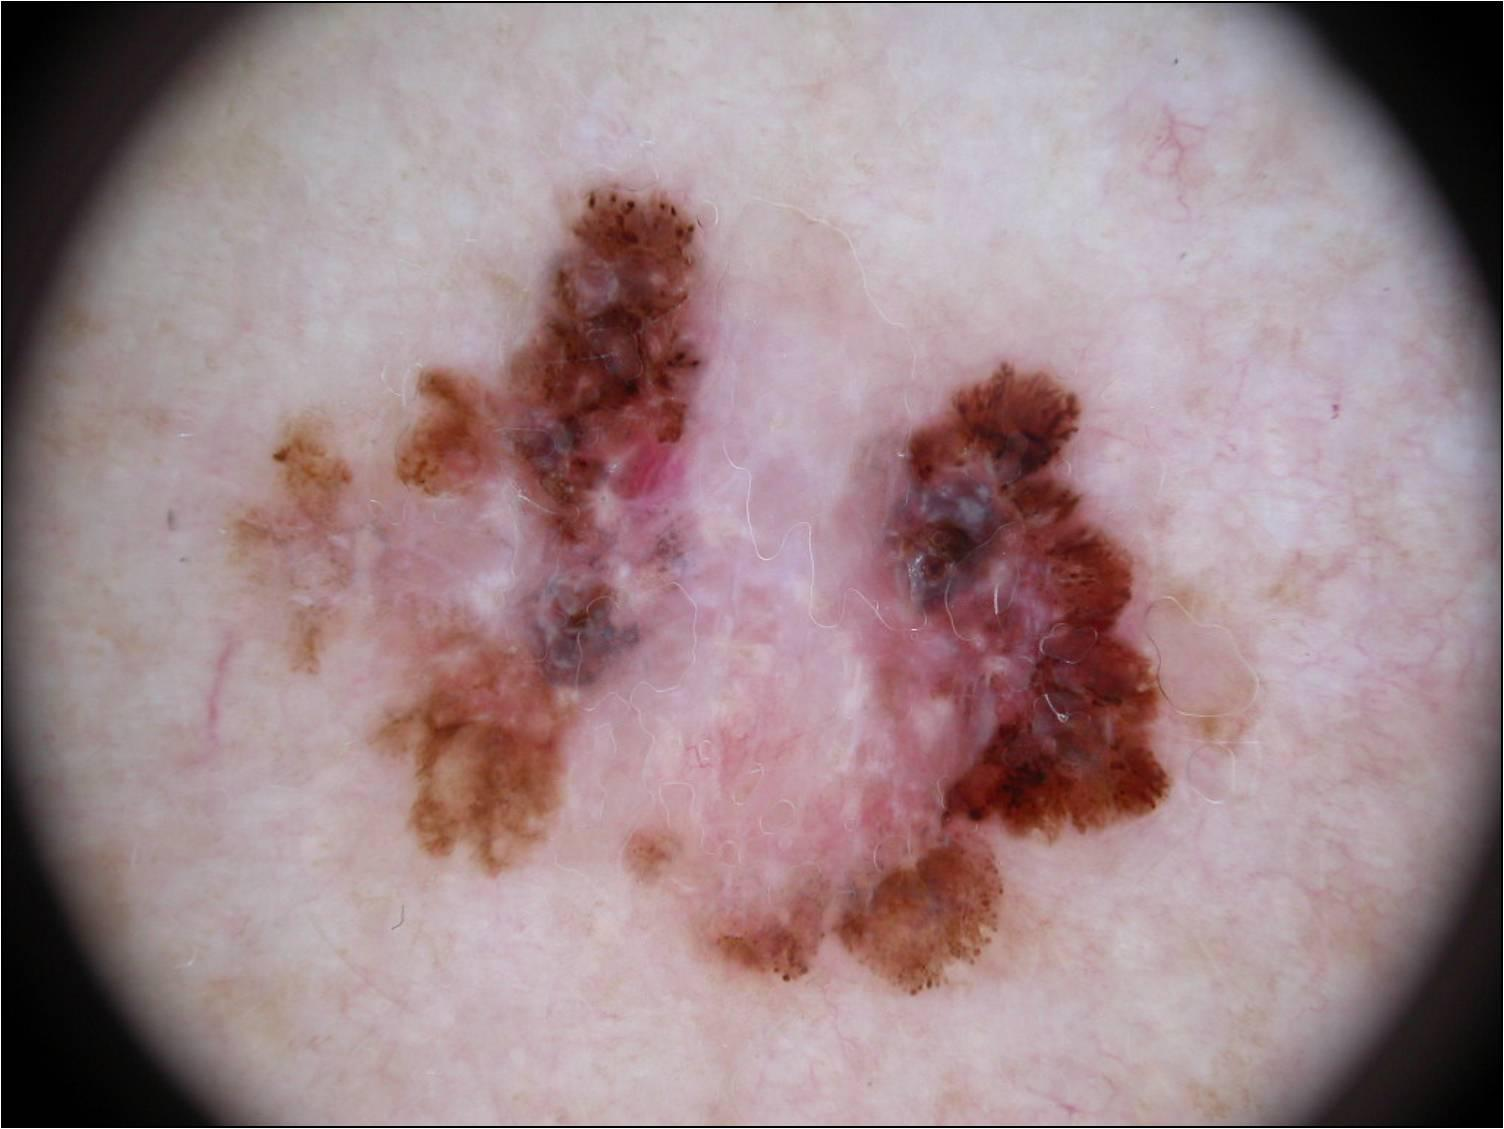

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

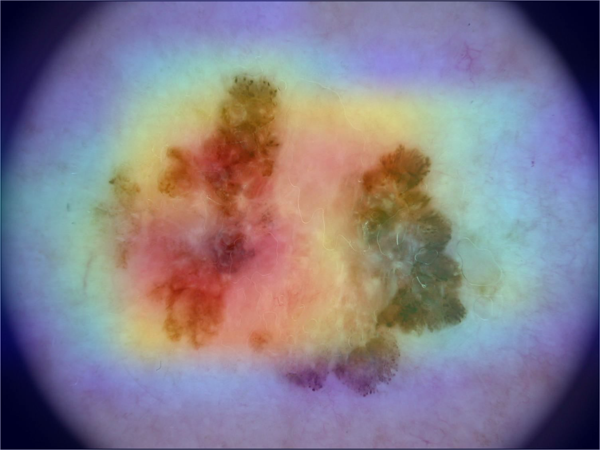

In [23]:
display_gradcam(melanoma_im_path, heatmap)